# Exercise - Unconstrained Optimization

## Data

All the analysis below applies to the data set,
* `data/spx_weekly_returns.xlsx`
* The file has **weekly** returns.
* For annualization, use 52 periods per year.

Consider only the following 10 stocks...

In [1]:
TICKS =  ['AAPL','NVDA','MSFT','GOOGL','AMZN','META','TSLA','AVGO','BRK/B','LLY']

As well as the ETF,

In [2]:
TICK_ETF = 'SPY'

### Data Processing

In [3]:
import pandas as pd

In [4]:
INFILE = '../data/spx_returns_weekly.xlsx'
SHEET_INFO = 's&p500 names'
SHEET_RETURNS = 's&p500 rets'
SHEET_BENCH = 'benchmark rets'

FREQ = 52

In [5]:
info = pd.read_excel(INFILE,sheet_name=SHEET_INFO)
info.set_index('ticker',inplace=True)
info.loc[TICKS]

,name,mkt cap
ticker,,
AAPL,Apple Inc,3.008822e+12
NVDA,NVIDIA Corp,3.480172e+12
MSFT,Microsoft Corp,3.513735e+12
GOOGL,Alphabet Inc,2.145918e+12
AMZN,Amazon.com Inc,2.303536e+12
META,Meta Platforms Inc,1.745094e+12
TSLA,Tesla Inc,9.939227e+11
AVGO,Broadcom Inc,1.148592e+12
BRK/B,Berkshire Hathaway Inc,1.064240e+12


In [6]:
rets = pd.read_excel(INFILE,sheet_name=SHEET_RETURNS)
rets.set_index('date',inplace=True)
rets = rets[TICKS]

In [7]:
bench = pd.read_excel(INFILE,sheet_name=SHEET_BENCH)
bench.set_index('date',inplace=True)
rets[TICK_ETF] = bench[TICK_ETF]

***

# 1. Risk Statistics

### 1.1.

Display a table with the following metrics for each of the return series.

* mean (annualized)
* volatility (annualized)
* Sharpe ratio (annualized)
* skewness
* kurtosis
* maximum drawdown

#### Note
We  have total returns, and Sharpe ratio is technically defined for excess returns. Don't worry about the difference. (Or subtract `SHV` if you prefer.)

In [8]:
rets.describe()

metrics = pd.DataFrame({
    'mean': rets.mean(),
    'vol': rets.std(),
    'sharpe': (rets.mean() - rets[TICK_ETF].mean())/(rets.std()),
    'skewness': rets.skew(),
    'kurtosis': rets.kurtosis(),
})

def compute_mdd(series):
    cumulative = (1+series).cumprod() # cumulative product
    
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

metrics['MDD'] = compute_mdd(rets)

metrics.head(10)

,mean,vol,sharpe,skewness,kurtosis,MDD
AAPL,0.004591,0.038362,0.053865,-0.218583,1.825875,-0.346408
NVDA,0.012415,0.064246,0.153951,0.344741,1.389069,-0.659362
MSFT,0.005027,0.033279,0.075201,0.072148,2.341547,-0.350539
GOOGL,0.004169,0.038808,0.042386,0.582916,3.720739,-0.418640
AMZN,0.005643,0.042435,0.073499,0.063289,1.781508,-0.548307
META,0.005037,0.048722,0.051572,0.052425,4.023529,-0.760252
TSLA,0.009034,0.081323,0.080044,0.547533,1.594181,-0.722459
AVGO,0.007593,0.052021,0.097441,0.662112,3.503558,-0.400357
BRK/B,0.002597,0.026439,0.002736,-0.200855,2.513168,-0.264770
LLY,0.005414,0.039242,0.073644,0.216020,1.683187,-0.252524


### 1.2.

As a standalone investment, which is most attractive? And least? Justify your answer.

NVDA has the highest Sharpe, 2nd highest vol, and a high drawdown, but that was before structural changes in its market.

### 1.3.

For each investment, estimate a regression against `SPY`. Report the 
* alpha (annualized as a mean)
* beta
* info ratio
* r-squared

Based on this table, which investment seems most attractive relative to holding `SPY`?

In [ ]:
import numpy as np
import pandas as pd

spy = bench['SPY']

for stock in rets.columns:
    hfri_factors = pd.concat([hfri, factors], axis=1)

    # Drop rows where either this fund OR SPY has NAs
    clean_hfri_factors = hfri_factors.dropna()
    # Prepare the independent variables (factors with constant)
    X = sm.add_constant(clean_hfri_factors[factors.columns])

    # Run OLS regression: fund returns = alpha + beta * SPY returns
    model = sm.OLS(clean_hfri_factors[hfri_col], X).fit()
    print(f"\nRegression Results:")
    print(f"Alpha/intercept: {model.params['const']:.6f}")
    print(f"Number of observations: {model.nobs}")
    for factor in factors.columns:
        print(f"{factor} beta: {model.params[factor]:.6f}")
        print("-" * 50)

***

# 2. Portfolio Allocation

### 2.1.

Display the correlation matrix of the returns.

* Based on this information, which investment do you anticipate will get extra weight in the portfolio, beyond what it would merit for its mean return?

* Report the maximally correlated assets and the minimally correlated assets.

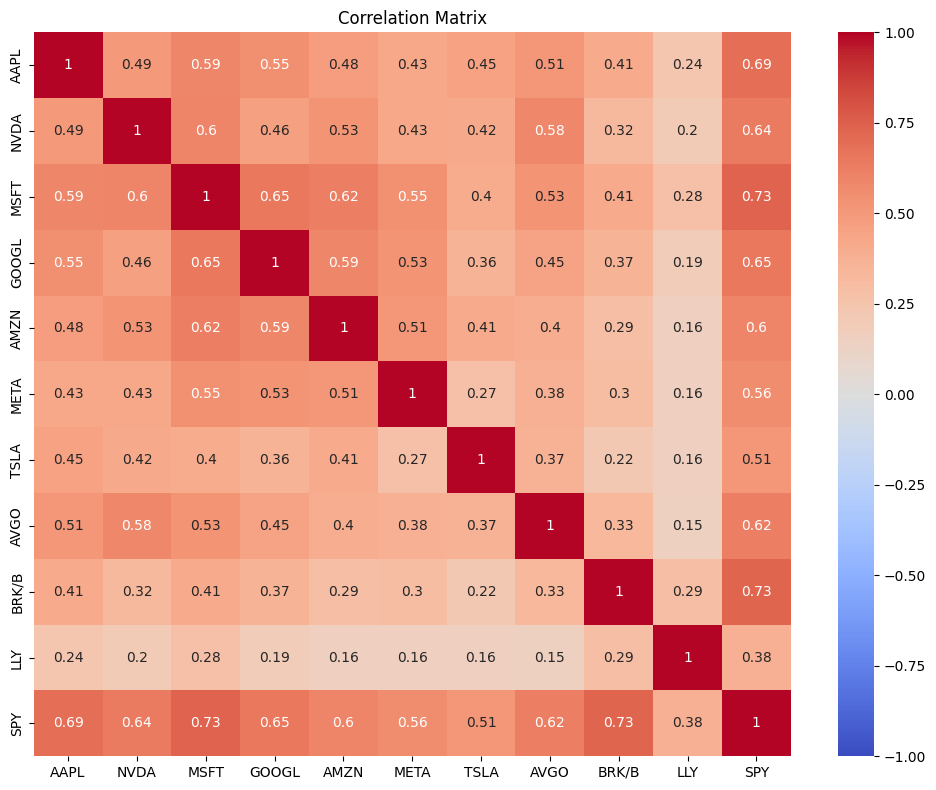

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = rets.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Blue to red color scheme
            center=0,  # Center colormap at 0
            vmin=-1, vmax=1)  # Set range from -1 to 1
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Most correlated assets: MSFT & SPY, BRK/B & SPY

Least correlated assets: LLY & AVGO

### 2.2.

Calculate the weights of the mean-variance optimized portfolio, also called the tangency portfolio.

* Display a table indexed by each investment, with the optimal weights in one column and the Sharpe ratios in another column.

* Do the investments with the best Sharpe ratios tend to get the biggest weights?

#### Note:
To estimate the optimal weights, consider using the provided function below.

In [ ]:
def optimized_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    if returns.mean() @ weights < 0:
        weights = -weights

    return pd.DataFrame(weights, index=returns.columns, columns=["optimal weights"])

optim_w = optimized_weights(rets)
w_metrics = optim_w.merge(metrics, how="outer", left_index=True, right_index=True)
w_metrics.sort_values(by="sharpe", ascending=False)

,optimal weights,mean,vol,sharpe,skewness,kurtosis,MDD
NVDA,0.882896,0.012415,0.064246,0.153951,0.344741,1.389069,-0.659362
AVGO,0.601896,0.007593,0.052021,0.097441,0.662112,3.503558,-0.400357
TSLA,0.310150,0.009034,0.081323,0.080044,0.547533,1.594181,-0.722459
MSFT,0.848584,0.005027,0.033279,0.075201,0.072148,2.341547,-0.350539
LLY,1.112630,0.005414,0.039242,0.073644,0.216020,1.683187,-0.252524
AMZN,0.426356,0.005643,0.042435,0.073499,0.063289,1.781508,-0.548307
AAPL,0.409367,0.004591,0.038362,0.053865,-0.218583,1.825875,-0.346408
META,0.277408,0.005037,0.048722,0.051572,0.052425,4.023529,-0.760252
GOOGL,0.193126,0.004169,0.038808,0.042386,0.582916,3.720739,-0.418640
BRK/B,2.580474,0.002597,0.026439,0.002736,-0.200855,2.513168,-0.264770


### 2.3.

Report the following performance statistics of the portfolio achieved with the optimized weights calculated above.
* mean
* volatility
* Sharpe

(Annualize all three statistics.)

In [ ]:
mean = w_metrics["mean"].dot(w_metrics["optimal weights"])

cov_matrix = w_metrics["mean"].cov
vol = w_metrics["optimal weights"] @ cov_matrix @ w_metrics["optimal weights"]

sharpe = w_metrics["mean"].dot(w_metrics["optimal weights"])
print(f"Mean: {mean}\nVol: {vol}\nSharpe: {sharpe}")

Mean: 0.02504283913410339
Vol: 0.02504283913410339
Sharpe: 0.02504283913410339


### 2.4.

Try dropping the asset which had the biggest short position from the investment set. Re-run the optimization. What do you think of these new weights compared to the original optimized weights?

What is going on?

****